This notebook contains code and results for multitask model predicting veracity and emotion simultaneously.

In [ ]:
# Run this line the first time you run this notebook, then comment it out. 
# If running on Google Colab, resturt runtime after running. 
!python -m pip install Keras==2.3.1 tensorflow==2.1.0

In [27]:
import nltk
import numpy as np
import pandas as pd
import re

from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [2]:
def clean_text(text):
    text = text.lower()
             
    # Process opeations and common punctuation.           
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    # Remove all remaining symbols.
    text = re.sub(r'[^a-z0-9]', ' ', text)
    
    # Remove stopwords and lemmatize.
    text = text.split()
    stop_words = stopwords.words("english")
    text = [tok for tok in text if tok not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    return ' '.join(text)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
df = pd.read_csv('../data/results/amazon_final.csv')

In [7]:
# Only leave relevant entries for the task.
amazon_multi = df[['REVIEW_TEXT', 'PREDICTION', 'VERACITY']].copy()

In [8]:
amazon_multi['REVIEW_TEXT'] = amazon_multi['REVIEW_TEXT'].apply(lambda x: clean_text(x))

In [9]:
# Get the number of unique words to choose proper vocabulary size.
all_words = []
for entry in amazon_multi['REVIEW_TEXT']:
    all_words += entry.split()
print('Number of unique words:', len(set(all_words)))

Number of unique words: 21749


In [10]:
vocabulary_size = 21000 
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(amazon_multi['REVIEW_TEXT'])
sequences = tokenizer.texts_to_sequences(amazon_multi['REVIEW_TEXT'])

In [11]:
# Encode outputs.
amazon_multi["PREDICTION"].replace({"joy": 0, "fear": 1, 'neutral': 2, 'anger': 3, 'sadness': 4}, inplace=True)
amazon_multi["VERACITY"].replace({"Fake": 0, "Real": 1}, inplace=True)

In [12]:
output_columns_all = ['PREDICTION', 'VERACITY']

In [13]:
# Pads sequences to the same length: MAXLEN
MAXLEN = 500
X = pad_sequences(sequences, maxlen=MAXLEN)
y = amazon_multi[output_columns_all]

In [41]:
# Leave 10% of data for test, and split training test into training and validation subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1)

In [42]:
output_columns_binary = ['VERACITY']
output_columns_categorical = ['PREDICTION']

In [43]:
# Since data is highly imbalanced, define class weights.
class_weights_categorical = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train['PREDICTION']),
                                                 y_train['PREDICTION'])
class_weights_binary = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train['VERACITY']),
                                                 y_train['VERACITY'])
classes_weights = {'VERACITY': class_weights_binary, 'PREDICTION': class_weights_categorical}

In [44]:
# Define model architecture.
input = Input(shape=(MAXLEN,), name='input')
x = Embedding(input_dim=vocabulary_size, output_dim=2, input_length=MAXLEN)(input)
x = Dropout(0.3)(x)
x = Conv1D(64 , 5, activation='relu')(x)
x = MaxPooling1D(pool_size=4)(x)
x = LSTM(100)(x) 

In [45]:
output_array = [] 
metrics_array = {}
loss_array = {}

binary_output = Dense(1, activation='sigmoid', name='veracity_output')(x)
output_array.append(binary_output)
metrics_array['veracity_output'] = 'binary_accuracy'
loss_array['veracity_output'] = 'binary_crossentropy'

In [46]:
categorical_output = Dense(5, activation='softmax', name='categorical_output')(x)
output_array.append(categorical_output)
metrics_array['categorical_output'] = 'sparse_categorical_accuracy'
loss_array['categorical_output'] = 'sparse_categorical_crossentropy'

In [47]:
model = Model(inputs=input, outputs=output_array)

In [48]:
model.compile(optimizer='adam',
              loss=loss_array,
              metrics = metrics_array)

In [49]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 500, 2)       42000       input[0][0]                      
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 500, 2)       0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 496, 64)      704         dropout_3[0][0]                  
____________________________________________________________________________________________

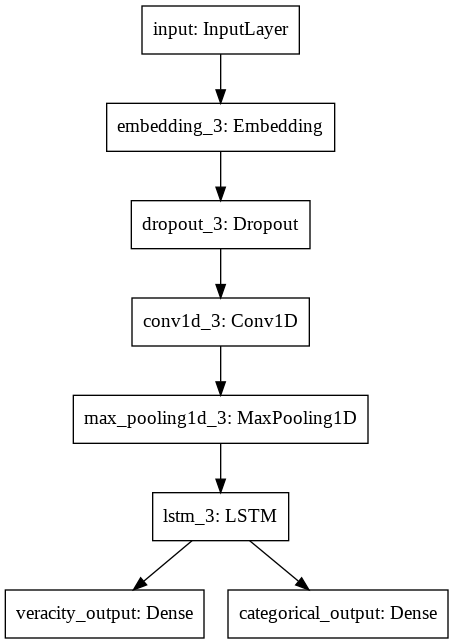

In [50]:
plot_model(model, to_file='model_plot.png')

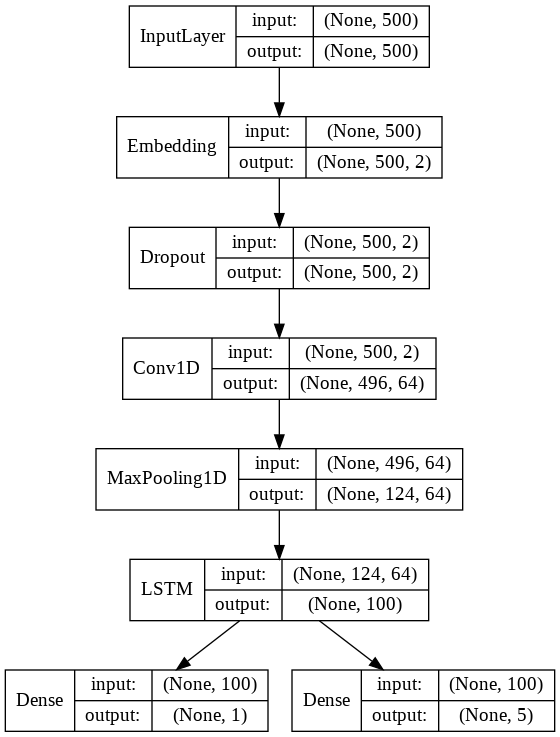

In [51]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False,)

In [52]:
y_train_output = [y_train['VERACITY'], y_train['PREDICTION']]
y_dev_output = [y_dev['VERACITY'], y_dev['PREDICTION']]

In [53]:
early_stopping_monitor = EarlyStopping(
    monitor='categorical_output_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


In [54]:
model.fit(X_train, y_train_output,
          epochs=50, 
          batch_size=128,
          class_weight=classes_weights, 
          verbose=1, 
          validation_data=(X_dev,y_dev_output),
          callbacks=[early_stopping_monitor])

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11303 samples, validate on 1256 samples
Epoch 1/50
11303/11303 [==============================] - 41s 4ms/step - loss: 1.8980 - veracity_output_loss: 0.6938 - categorical_output_loss: 1.2044 - veracity_output_binary_accuracy: 0.5158 - categorical_output_sparse_categorical_accuracy: 0.5731 - val_loss: 1.8734 - val_veracity_output_loss: 0.6925 - val_categorical_output_loss: 1.1793 - val_veracity_output_binary_accuracy: 0.5175 - val_categorical_output_sparse_categorical_accuracy: 0.5661
Epoch 2/50
11303/11303 [==============================] - 40s 4ms/step - loss: 1.7204 - veracity_output_loss: 0.6883 - categorical_output_loss: 1.0298 - veracity_output_binary_accuracy: 0.5339 - categorical_output_sparse_categorical_accuracy: 0.6141 - val_loss: 1.6336 - val_veracity_output_loss: 0.6838 - val_categorical_output_loss: 0.9481 - val_veracity_output_binary_accuracy: 0.5629 - val_categorical_output_sparse_categorical_accuracy: 0.6831
Epoch 3/50
11303/11303 [=============================

In [66]:
THRESHOLD = 0.5
y_pred = model.predict(X_test)

# Veracity Output.
y_pred[0][y_pred[0]>=THRESHOLD] = 1
y_pred[0][y_pred[0]<THRESHOLD] = 0
print('Veracity prediction accuracy:\n')
print(classification_report(y_test[output_columns_binary[0]], y_pred[0], target_names=['Fake', 'Real']))

# Emotion Classification Output
y_pred_emo = np.argmax(y_pred[1], axis=1)
print('Emotion classification accuracy:\n')
print(classification_report(y_test[output_columns_categorical], y_pred_emo, target_names=['joy', 'fear', 'neutral', 'anger', 'sadness']))

Veracity prediction accuracy:

              precision    recall  f1-score   support

        Fake       0.65      0.45      0.53       746
        Real       0.53      0.72      0.61       650

    accuracy                           0.58      1396
   macro avg       0.59      0.58      0.57      1396
weighted avg       0.59      0.58      0.57      1396

Emotion classification accuracy:

              precision    recall  f1-score   support

         joy       0.89      0.80      0.84       797
        fear       0.14      0.03      0.05        63
     neutral       0.31      0.53      0.39       186
       anger       0.60      0.66      0.63       313
     sadness       0.00      0.00      0.00        37

    accuracy                           0.68      1396
   macro avg       0.39      0.41      0.38      1396
weighted avg       0.69      0.68      0.68      1396



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('../trained_models/multitask_model.h5')